# **Duplicate Question Pairs**

## Data Preprocessing 

In [74]:
# importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
# importing dataset

df = pd.read_csv('questions.csv')

In [76]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [77]:
# selecting randomly 50000 rows

new_df = df.sample(150000, random_state=2)

In [78]:
# checking null values

new_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [79]:
# checking duplicate values

new_df.duplicated().sum()

0

In [80]:
# checking values in target variables

print(new_df['is_duplicate'].value_counts())
(new_df['is_duplicate'].value_counts()/new_df['is_duplicate'].count())*100

is_duplicate
0    94390
1    55610
Name: count, dtype: int64


is_duplicate
0    62.926667
1    37.073333
Name: count, dtype: float64

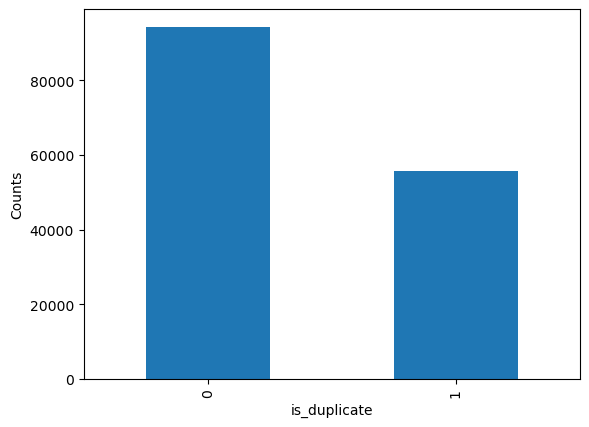

In [81]:
# plotting target values

new_df['is_duplicate'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.show()

## Feature Engineering

In [82]:
# creating new feature, length of charectors

new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [83]:
# length of questions 

new_df['q1_num_word'] = new_df['question1'].apply(lambda itr: len(itr.split(" ")))
new_df['q2_num_word'] = new_df['question2'].apply(lambda itr: len(itr.split(" ")))

In [84]:
# counting common words in both questions

def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1 & w2)

In [85]:
new_df['common_words'] = new_df.apply(common_words, axis=1)

In [86]:
# counting total words in both questions

def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return len(w1) + len(w2)

In [87]:
new_df['total_words'] = new_df.apply(total_words, axis=1)

In [88]:
# word share = common words in questions/ total words in both questions

new_df['word_share'] = round(new_df['common_words']/new_df['total_words'] + 0.0021, 2)

In [89]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_word,q2_num_word,common_words,total_words,word_share
289024,289024,20941,8014,What should I do in order not to care about wh...,"As an individual, do I really need to care wha...",1,68,70,15,14,9,28,0.32
3454,3454,6846,6847,Why AAP’s MLA Dinesh Mohaniya has been arrested?,What are your views on the latest sex scandal ...,0,48,71,8,14,1,22,0.05
92547,92547,154928,154929,Requisites to become first time app developer?,What Jobs are available on Cruise Ships for a ...,0,46,61,7,11,0,18,0.00
102544,102544,10473,2581,Is it possible to time travel to past?,Is time travel still theorized as being possible?,1,38,49,8,8,3,15,0.20
173136,173136,267166,267167,What preparation you should make before gettin...,How should you prepare your body before gettin...,1,57,57,8,9,5,17,0.30


In [90]:
new_df.shape

(150000, 13)

c:\Users\masan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Minimul length of question is  1
Maximum length of question is  391
Average length of question is  59.41079333333333


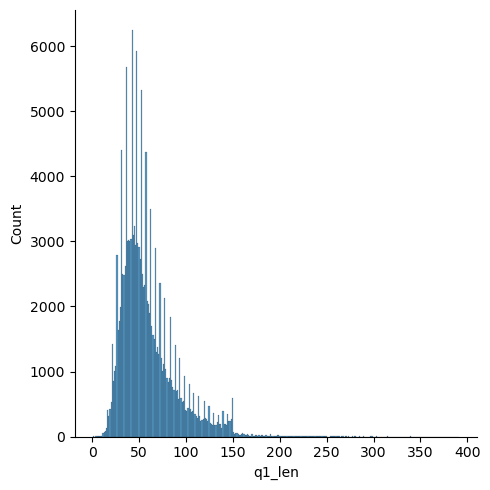

In [91]:
# distribution of length of question_1

sns.displot(new_df['q1_len'])
print('Minimul length of question is ', new_df['q1_len'].min())
print('Maximum length of question is ', new_df['q1_len'].max())
print('Average length of question is ', round(new_df['q1_len'].mean(), 2))

c:\Users\masan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Minimul length of question is  3
Maximum length of question is  1169
Average length of question is  59.955146666666664


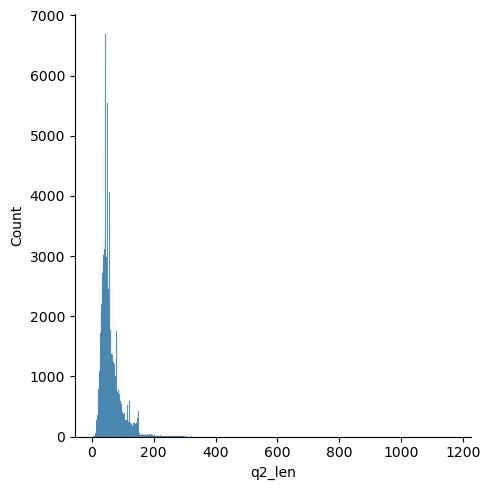

In [92]:
# distribution of length of question_2

sns.displot(new_df['q2_len'])
print('Minimul length of question is ', new_df['q2_len'].min())
print('Maximum length of question is ', new_df['q2_len'].max())
print('Average length of question is ', round(new_df['q2_len'].mean()), 2)

c:\Users\masan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Minimul words in question_1 is  1
Maximum words in question_1 is  73
Average words in question_1 is  10.92224


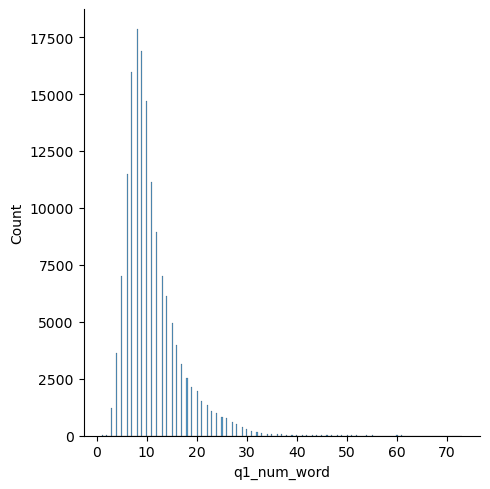

In [93]:
# distribution of number of number of words in question_1

sns.displot(new_df['q1_num_word'])
print('Minimul words in question_1 is ', new_df['q1_num_word'].min())
print('Maximum words in question_1 is ', new_df['q1_num_word'].max())
print('Average words in question_1 is ', round(new_df['q1_num_word'].mean(), 2))

c:\Users\masan\anaconda3\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Minimul words in question_2 is  1
Maximum words in question_2 is  237
Average words in question_2 is  11.160753333333334


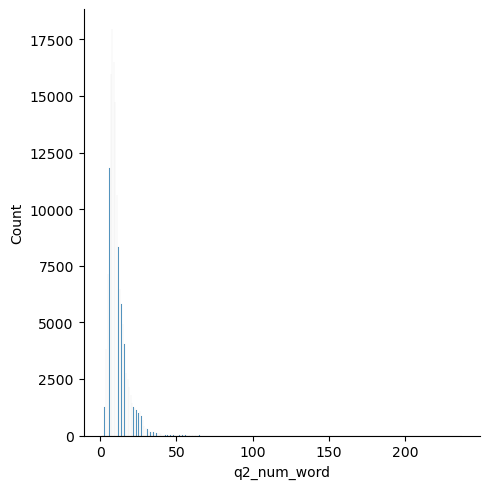

In [94]:
# distribution of number of words in quesion_2

sns.displot(new_df['q2_num_word'])
print('Minimul words in question_2 is ', new_df['q2_num_word'].min())
print('Maximum words in question_2 is ', new_df['q2_num_word'].max())
print('Average words in question_2 is ', round(new_df['q2_num_word'].mean(), 2))

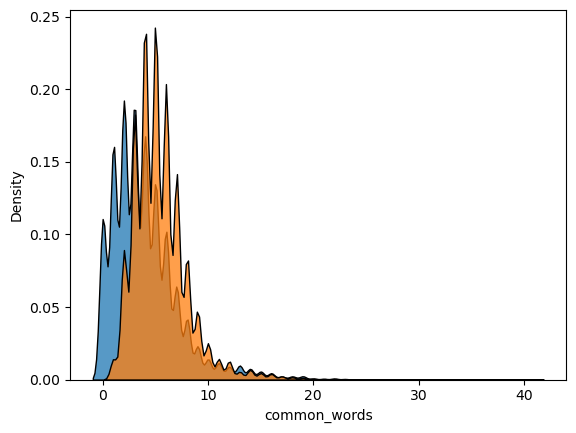

In [95]:
# kde plot of common words 

sns.kdeplot(data = new_df[new_df['is_duplicate'] == 0]['common_words'], legend=True, multiple='stack')
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 1]['common_words'], legend=True, multiple='stack')
plt.show()

In [96]:
# observations

# in above plot we can see that as number of common words increases, probability for duplicate question pair increases 

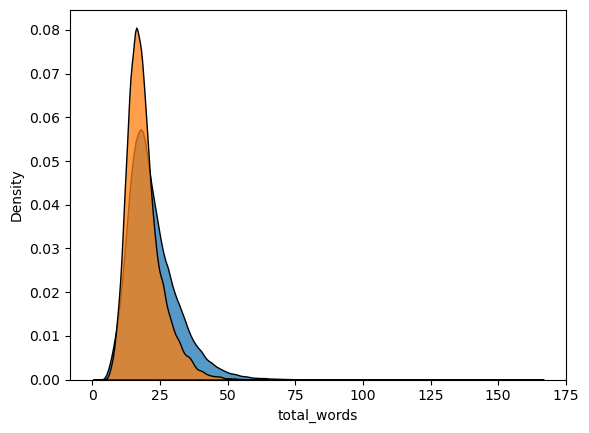

In [97]:
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 0]['total_words'], legend=True, multiple='stack')
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 1]['total_words'], legend=True, multiple='stack')
plt.show()

In [98]:
# observations

# as total words increases probability for question pair is not duplicate increases

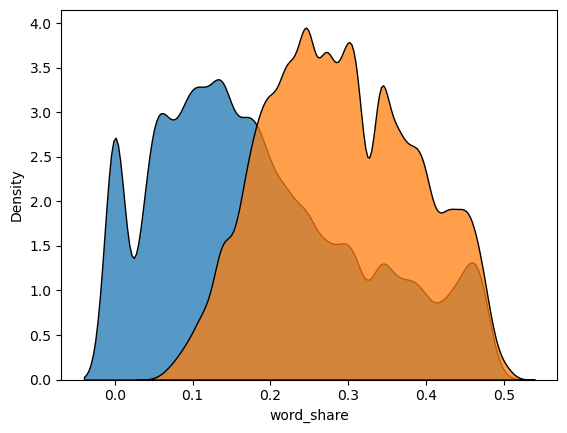

In [99]:
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 0]['word_share'], legend=True, multiple='stack')
sns.kdeplot(data = new_df[new_df['is_duplicate'] == 1]['word_share'], legend=True, multiple='stack')
plt.show()

In [100]:
# observations

# as word share increases, probability of duplicate question pair increases

In [101]:
# creating bag of words

from sklearn.feature_extraction.text import CountVectorizer

questions = list(new_df['question1']) + list(new_df["question2"])

cv = CountVectorizer(max_features=3000)
q1_arr, q2_arr = np.vsplit(cv.fit_transform(questions).toarray(), 2)

In [102]:
temp1 = pd.DataFrame(q1_arr, index=new_df.index)
temp2 = pd.DataFrame(q2_arr, index=new_df.index)

temp_df = pd.concat([temp1, temp2], axis=1)

temp_df.shape

(150000, 6000)

In [103]:
new_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'q1_len', 'q2_len', 'q1_num_word', 'q2_num_word', 'common_words',
       'total_words', 'word_share'],
      dtype='object')

In [104]:
new_df.drop(columns = ['id', 'qid1', 'qid2', 'question1', 'question2'], inplace=True)

In [105]:
# main dataframe which is to be given to model

main_df = pd.concat([new_df, temp_df], axis=1)

In [106]:
main_df.head()

,is_duplicate,q1_len,q2_len,q1_num_word,q2_num_word,common_words,total_words,word_share,0,1,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
289024,1,68,70,15,14,9,28,0.32,0,0,...,0,0,0,0,0,0,0,0,0,0
3454,0,48,71,8,14,1,22,0.05,0,0,...,0,0,0,0,1,0,0,0,0,0
92547,0,46,61,7,11,0,18,0.00,0,0,...,0,0,0,0,0,0,0,0,0,0
102544,1,38,49,8,8,3,15,0.20,0,0,...,0,0,0,0,0,0,0,0,0,0
173136,1,57,57,8,9,5,17,0.30,0,0,...,0,1,0,0,1,0,0,0,0,0


In [107]:
main_df.shape

(150000, 6008)

## Model Building 

In [108]:
# seperating dataset into X and y

X = main_df.drop(columns=['is_duplicate']).values
y = main_df['is_duplicate'].values

In [109]:
# splitting dataset for training and testing 

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)



In [110]:
# random forest classifier model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)
accuracy_score(y_test, y_pred)

0.8038933333333333

In [111]:
# xgbclassifier model

from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)
accuracy_score(y_test, y_pred)

0.7872533333333334